In [1]:
from src.model.city import City
from src.simulation.simulation import Simulation, time_of_number_of_days
from src.data_processing import bikes_scoring, station_changes, processing_constants

In [2]:
city = City.from_numbers(600, 100).assign_bikes_randomly()
time = time_of_number_of_days(7)
simulaiton = Simulation()

simulaiton.simulate(city, time)

simulating: 100%|█████████████████████████| 2016/2016 [00:04<00:00, 454.45it/s]


In [3]:
broken_bikes = simulaiton.get_breaking_bikes_data()
trips_history = simulaiton.get_stations_data()

In [5]:
scores = bikes_scoring.BikesScoring(station_changes.StationChanges(trips_history).find_stations_changes()).score_bikes()

scoring bikes: 100%|████████████████| 201500/201500 [00:20<00:00, 10027.42it/s]


In [29]:
broken_bikes.head(20)

,timestamp,bike_id
0,15,377
1,50,591
2,57,367
3,78,82
4,93,290
5,143,321
6,267,536
7,314,43
8,327,570
9,354,551


In [7]:
# "hour aggregates"
scores["hour"] = scores["timestamp"].apply(lambda x: int(x/12))
scores

,bike_id,timestamp,plus,minus,hour
0,103,1,0,0.166667,0
1,201,1,0,0.166667,0
2,569,1,0,0.166667,0
3,59,1,0,0.166667,0
4,571,1,0,0.166667,0
...,...,...,...,...,...
406608,384,2014,0,0.200000,167
406609,394,2014,0,0.200000,167
406610,139,2014,0,0.200000,167
406611,432,2014,0,0.200000,167


In [25]:
aggregates = scores.drop(["timestamp"], axis=1).groupby(["bike_id", "hour"]).sum()
aggregates["total"] = aggregates.plus - aggregates.minus
aggregates.total

bike_id  hour
0        0       0.833333
         1       1.430556
         2       2.000000
         3      -1.238492
         4      -0.694444
                   ...   
599      163    -0.842857
         164    -0.840079
         165    -0.845238
         166     0.332143
         167     0.652778
Name: total, Length: 100518, dtype: float64

In [30]:
bike_43 = aggregates.loc[43]

In [31]:
import seaborn as sns

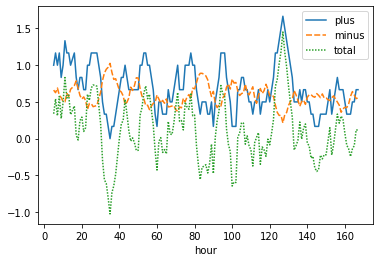

In [42]:
sns.lineplot(data=bike_43.rolling(6).mean())

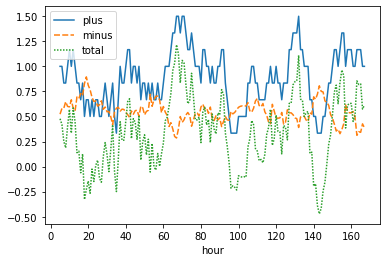

In [43]:
sns.lineplot(data=aggregates.loc[0].rolling(6).mean())